In [1]:
import gmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.apps.linear_elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot

In [2]:
dt.config()

In [13]:
lc = 0.5
gmsh.initialize()
gmsh.model.add("t1")
gmsh.model.geo.addPoint(1, 0, 0, lc, 1)
gmsh.model.geo.addPoint(0, 0, 0, lc, 2)
gmsh.model.geo.addPoint(1, 1, 0, lc, 3)
gmsh.model.geo.addPoint(0, 1, 0, lc, 4)

gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 4, 2)
gmsh.model.geo.addLine(4, 3, 3)
gmsh.model.geo.addLine(3, 1, 4)
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.synchronize()
gmsh.model.addPhysicalGroup(1, [1, 2, 3, 4], 1)
gmsh.model.addPhysicalGroup(1, [2], 2, name="left")
gmsh.model.addPhysicalGroup(1, [4], 3, name="right")
gmsh.model.mesh.generate(2)

num_nodes, num_elements, S_2, node_coords, bnd_faces_tags = util.read_mesh()
left_bnd_nodes_idx, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)
right_bnd_nodes_idx, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 3)
left_bnd_nodes_idx -= 1
right_bnd_nodes_idx -= 1
# makes concatenation easier when assigning bcs
left_bnd_nodes_idx = list(left_bnd_nodes_idx)
right_bnd_nodes_idx = list(right_bnd_nodes_idx)
print(left_bnd_nodes_idx, right_bnd_nodes_idx)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000200698s, CPU 0.000197s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000290122s, CPU 0.000247s)
Info    : 12 nodes 26 elements
[1, 3, 5] [0, 2, 7]


In [4]:
S = simplex.SimplicialComplex(S_2, node_coords, bnd_faces_tags=bnd_faces_tags, is_well_centered=True)
S.get_circumcenters()
S.get_primal_volumes()
S.get_dual_volumes()
S.get_hodge_star()
S.get_dual_edge_vectors()
S.get_flat_weights()

In [5]:
mu_ = 1.
lambda_ = 10.
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 1000.

left_bnd_nodes_pos = S.node_coord[left_bnd_nodes_idx, :]
right_bnd_nodes_pos = S.node_coord[right_bnd_nodes_idx, :]
right_bnd_nodes_pos[:,0] *= 1.1
print(left_bnd_nodes_pos)
num_faces = S.S[2].shape[0]
embedded_dim = S.embedded_dim
clamped_bnd_pos = np.vstack((left_bnd_nodes_pos,right_bnd_nodes_pos))
clamped_bnd_idx = left_bnd_nodes_idx + right_bnd_nodes_idx

[[0.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.5 0. ]]


In [6]:
f = np.zeros((num_faces, (embedded_dim-1)))
f_flattened = f.flatten()
node_coords_flattened = S.node_coord.flatten()
boundary_values = (clamped_bnd_idx, clamped_bnd_pos)

idx_tractions = jnp.array([0,3,6,10])
bnd_tractions_values = jnp.zeros((4,2), dtype = dt.float_dtype)
boundary_tractions = (idx_tractions, bnd_tractions_values)

obj_args = {'f': f_flattened, 'gamma': gamma, 'boundary_values': boundary_values, 
            'boundary_tractions': boundary_tractions}

prb = optctrl.OptimizationProblem(dim=S.node_coord.size,
                                  state_dim=S.node_coord.size,
                                  objfun=ela.obj_linear_elasticity)

In [7]:
prb.set_obj_args(obj_args)
sol = prb.run(x0=node_coords_flattened)
curr_node_coords = sol.reshape(S.node_coord.shape)
print(prb.last_opt_result)

3


In [8]:
strain = ela.get_strain(curr_node_coords)
stress = ela.get_stress(strain)
# print("curr_metric=", S.get_current_metric_2D(curr_node_coords))
print("strain=", strain)
print("stress=", stress)

strain= [[[ 8.77491214e-02  5.31428262e-02]
  [ 5.31428262e-02 -6.84742398e-02]]

 [[ 9.95248252e-02  7.19988549e-02]
  [ 7.19988549e-02 -7.78243752e-02]]

 [[ 7.49957010e-02  4.83119471e-02]
  [ 4.83119471e-02 -5.92143537e-03]]

 [[ 7.43614621e-02  2.83660646e-02]
  [ 2.83660646e-02 -4.62788255e-03]]

 [[ 6.56373773e-02  5.38362078e-03]
  [ 5.38362078e-03  1.29324644e-03]]

 [[ 1.35589208e-01 -2.22242856e-02]
  [-2.22242856e-02 -1.23874397e-01]]

 [[ 7.28751235e-02 -1.87066622e-02]
  [-1.87066622e-02  2.37384105e-05]]

 [[ 1.38339395e-01 -4.91132111e-02]
  [-4.91132111e-02 -1.26253631e-01]]

 [[ 1.74100020e-01 -2.33878464e-02]
  [-2.33878464e-02 -1.45361078e-01]]

 [[ 1.80082347e-01 -3.91252050e-02]
  [-3.91252050e-02 -1.60857917e-01]]

 [[ 1.78371976e-01 -3.50506504e-02]
  [-3.50506504e-02 -9.92060338e-02]]

 [[ 7.06932106e-02  3.07824936e-02]
  [ 3.07824936e-02 -7.23757428e-02]]

 [[ 1.71793887e-01 -2.59142390e-02]
  [-2.59142390e-02 -1.10821118e-01]]

 [[ 7.20731611e-02  9.96109871

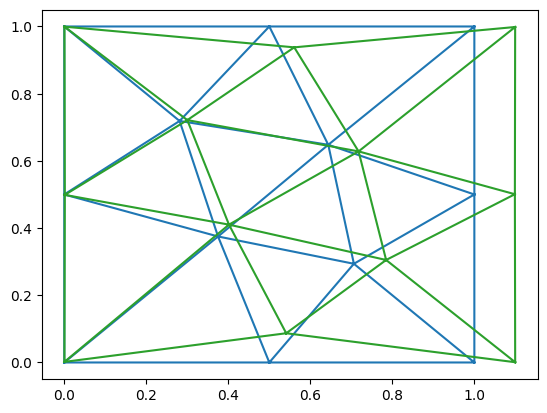

In [9]:
triplot(node_coords[:,0], node_coords[:,1], triangles=S_2)
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S_2)

In [10]:
from dctkit.dec import vector as V
stress_tensor = V.DiscreteTensorFieldD(S=S, coeffs=stress.T, rank=2)
stress_integrated = V.flat_DPD(stress_tensor)
forces = C.star(stress_integrated)
forces.coeffs

Array([[ 4.91132111e-02,  6.58248101e-02],
       [-4.37369433e-01,  1.87066622e-02],
       [-1.66943346e-01, -6.78190508e-02],
       [ 7.19988549e-02,  3.06778750e-02],
       [-4.20367029e-01, -4.83119471e-02],
       [-1.90531238e-01,  9.36813621e-02],
       [-5.31428262e-02, -2.79001683e-02],
       [ 4.23029360e-01,  2.83660646e-02],
       [ 1.85511957e-01, -1.04825588e-01],
       [ 4.00290496e-01,  5.38362078e-03],
       [-2.22242856e-02, -6.53003423e-02],
       [ 1.62453683e-01,  7.13827569e-02],
       [-1.53028744e-01, -3.93355873e-04],
       [-1.80568722e-01, -3.16071098e-02],
       [ 1.11129038e-01,  1.72676852e-01],
       [-1.07232318e-01,  8.84043705e-02],
       [ 1.68961778e-01,  2.46560459e-02],
       [ 1.46690537e-01,  4.77986946e-03],
       [ 1.19746799e-01, -1.06412913e-01],
       [-1.04022878e-01, -1.45636283e-01],
       [-4.40279988e-02, -6.84534851e-02],
       [-2.07350099e-01, -1.85711192e-03],
       [-3.01513637e-01,  1.46780689e-01],
       [-1.

In [11]:
print(curr_node_coords)
node_coord_final = node_coords.copy()
node_coord_final[:,0] *= 1.1
print(node_coord_final)
print(np.sum((node_coord_final - curr_node_coords)**2))

[[1.09955180e+00 7.62951656e-04 0.00000000e+00]
 [3.92141401e-04 1.76796376e-03 0.00000000e+00]
 [1.09949820e+00 9.98454500e-01 0.00000000e+00]
 [4.28226856e-04 9.99443005e-01 0.00000000e+00]
 [5.41222130e-01 8.70049058e-02 0.00000000e+00]
 [1.31118755e-03 4.98797578e-01 0.00000000e+00]
 [5.60790241e-01 9.37888015e-01 0.00000000e+00]
 [1.09881926e+00 5.00774284e-01 0.00000000e+00]
 [7.84868601e-01 3.05049130e-01 0.00000000e+00]
 [4.01633979e-01 4.10250026e-01 0.00000000e+00]
 [7.17709673e-01 6.28219836e-01 0.00000000e+00]
 [3.00045243e-01 7.21381877e-01 0.00000000e+00]]
[[1.1        0.         0.        ]
 [0.         0.         0.        ]
 [1.1        1.         0.        ]
 [0.         1.         0.        ]
 [0.55       0.         0.        ]
 [0.         0.5        0.        ]
 [0.55       1.         0.        ]
 [1.1        0.5        0.        ]
 [0.776875   0.29375    0.        ]
 [0.4125     0.375      0.        ]
 [0.708125   0.64791667 0.        ]
 [0.309375   0.71875    0. 